## Measuring regional outdoor recreation in the Bay Area using social media, in 3 different categories of land:  
1. Priority Conservation Areas (PCAs),
2. Protected Areas (Bay Area Protected Areas Database - BPAD) 
3. Natural landcover types (NLCD)

### And summarizing how much of the recreation in each category is exposed to sea-level rise, based on 10 different SLR scenarios.

This workflow depends on results from:
    * slr_rasters_align.py
    * userdays_rasteraoi.r
    * pud_rasterize.py

In [1]:
import numpy as np
from osgeo import gdal
gdal.UseExceptions()
import pygeoprocessing.geoprocessing as pgp
import os
import glob
import pandas as pd

In [2]:
workspace = '../data/bcdc_slr_regional_rec'

In [3]:
def raster2array(raster_uri):
    '''
    helper function to go straight from raster filename to 2-d numpy array
    '''
    src = gdal.Open(raster_uri)
    band1 = src.GetRasterBand(1)
    rows = src.RasterYSize
    cols = src.RasterXSize
    arr = band1.ReadAsArray(0, 0, cols, rows)
    return(arr)

### All datasources will be rasterized and aligned to the 30m NLCD grid

In [4]:
nlcd_uri = '../data/bcdc_othernaturalareas/NaturalAreas_ForDave/nlcd_nodevt_utm.tif'
nlcd_src = gdal.Open(nlcd_uri)

In [5]:
# PUD raster created by pud_rasterize.py
pud_uri = '../data/flickr/nlcd_grid_pud/pud_nlcdgrid.tif'
pud = raster2array(pud_uri)

In [6]:
# pgp.new_raster_from_base(nlcd_uri, base_uri, gdal.GDT_Int16, [99], [0])

#### Load AOIs and burn them onto a grid based on the NLCD raster

In [7]:
# BPAD 
bpad_uri = os.path.join(workspace, 'bpad.tif')
## only need to repeat this if the AOI changes
# pgp.new_raster_from_base(nlcd_uri, bpad_uri, gdal.GDT_Int16, [99], [0])
# shp_uri = '../data/bcdc_othernaturalareas/NaturalAreas_ForDave/BayAreaProtectedLands_utm.shp'
# pgp.rasterize(shp_uri, bpad_uri, [1], None)

In [8]:
# PCA -- only need to repeat this if the AOI changes
pca_uri = os.path.join(workspace, 'pca.tif')
## only need to repeat this if the AOI changes
# pgp.new_raster_from_base(nlcd_uri, pca_uri, gdal.GDT_Int16, [99], [0])
# shp_uri = '../data/pca/shapefiles/Priority_Conservation_Areas_current.shp'
# pgp.rasterize(shp_uri, pca_uri, [1], None)

#### read AOIs as 2d arrays for querying

In [9]:
# Natural Lands - make 2d array 0s and 1s where 1s are all lulc classes other than development
# in the original datasource, development lulc's have already been assigned nodata
band1 = nlcd_src.GetRasterBand(1)
nodata = band1.GetNoDataValue()
rows = nlcd_src.RasterYSize
cols = nlcd_src.RasterXSize
vals = band1.ReadAsArray(0, 0, cols, rows)
nlcd = np.ones_like(vals)
nlcd[vals == nodata] = 0

In [10]:
bpad = raster2array(bpad_uri)
pca = raster2array(pca_uri)

In [11]:
nlcd.shape == bpad.shape == pca.shape == pud.shape

True

## Count the photo-user-days across all grid cells included in combinations of the AOIs and SLR scenarios. 

#### All calculations exclude developed areas (based on lulc development classes)

### small example of how these 'presence/absence' arrays are used to count PUDs:

In [12]:
## setting up some toy datasets
np.random.seed(0)
b = np.zeros((5,5)).astype(int)
b[:5,:2] = 1
p = np.zeros((5,5)).astype(int)
p[:2,:3] = 1
s = np.zeros((5,5)).astype(int)
s[[0,4],:5] = 1
u = np.flip(np.random.poisson(size=25).astype(int).reshape(5, 5), 0)

In [13]:
b # could be presence of the BPAD network:

array([[1, 1, 0, 0, 0],
       [1, 1, 0, 0, 0],
       [1, 1, 0, 0, 0],
       [1, 1, 0, 0, 0],
       [1, 1, 0, 0, 0]])

In [14]:
p # could be presence of the PCA network:

array([[1, 1, 1, 0, 0],
       [1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [15]:
s # could be presence of SLR inundation from one scenario

array([[1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1]])

In [16]:
u # could be PUD values to count

array([[0, 0, 0, 1, 1],
       [2, 2, 1, 0, 2],
       [1, 2, 0, 1, 1],
       [1, 0, 0, 5, 1],
       [2, 1, 1, 2, 2]])

#### How many PUDs inside PCA network and exposed to inundation?

In [17]:
print((p == 1) & (s == 1))
np.sum(u[(p == 1) & (s == 1)])

[[ True  True  True False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]]


0

#### How many PUDs inside BPAD, outside of PCAs, and exposed to inundation?

In [18]:
print((b == 1) & (p == 0) & (s == 1))
np.sum(u[(b == 1) & (p == 0) & (s == 1)])

[[False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]
 [ True  True False False False]]


3

### Now the real thing
The nlcd grid is always used to exclude areas previously classified as development, and other areas with nodata

### PUDs in BPAD and PCA natural lands as proportion of total in all natural lands (nlcd)

In [19]:
## total PUD for each AOI (excluding developed areas)
nlcd_pud = float(np.sum(pud[(nlcd == 1)]))
bpad_pud = float(np.sum(pud[(nlcd == 1) & (bpad == 1)]))
pca_pud = float(np.sum(pud[(nlcd == 1) & (pca == 1)]))

print('PCA: ' + str(pca_pud/nlcd_pud*100))
print('BPAD: ' + str(bpad_pud/nlcd_pud*100))

PCA: 23.7966252833
BPAD: 62.3282901317


In [20]:
## total PUD inside each AOI and outside the other AOIs
bpad_pud = float(np.sum(pud[(nlcd == 1) & (bpad == 1) & (pca == 0)]))
pca_pud = float(np.sum(pud[(nlcd == 1) & (pca == 1)]))
nlcd_out_pud = float(np.sum(pud[(nlcd == 1) & (pca == 0) & (bpad == 0)]))

print('PCA: ' + str(pca_pud/nlcd_pud*100))
print('BPAD outside of PCA: ' + str(bpad_pud/nlcd_pud*100))
print('NLCD outside of BPAD & PCA: ' + str(nlcd_out_pud/nlcd_pud*100))

PCA: 23.7966252833
BPAD outside of PCA: 48.5023289214
NLCD outside of BPAD & PCA: 27.7010457952


### total PUD for each SLR scenario, and with exlcusive AOI pairings (e.g. inside BPAD & outside PCA)

In [21]:
slr_rasters = glob.glob('../data/pca/bcdc_slr/raster/aligned/Inundate*.tif')

In [22]:
# In PCA network, by SLR scenario
pca_slr = {}

for slr_uri in slr_rasters:
    print(slr_uri)
    slr = raster2array(slr_uri)
    assert pud.shape == nlcd.shape == pca.shape == slr.shape
    puds = np.sum(pud[(nlcd == 1) & \
                      (pca == 1) & \
                      (slr == 1)])
    pca_slr[os.path.basename(slr_uri)] = puds
    
puds_slr0 = np.sum(pud[(nlcd == 1) & \
                      (pca == 1)])
pca_slr['Inundate_0'] = puds_slr0

../data/pca/bcdc_slr/raster/aligned/Inundate_66.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_77.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_12.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_52.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_108.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_96.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_48.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_24.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_36.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_84.tif


In [23]:
# In BPAD network and not in PCA network, by SLR scenario
bpad_slr = {}

for slr_uri in slr_rasters:
    print(slr_uri)
    slr = raster2array(slr_uri)
    assert pud.shape == nlcd.shape == pca.shape == slr.shape
    puds = np.sum(pud[(nlcd == 1) & \
                      (bpad == 1) & \
                      (slr == 1) & \
                      (pca == 0)])
    bpad_slr[os.path.basename(slr_uri)] = puds
        
puds_slr0 = np.sum(pud[(nlcd == 1) & \
                      (bpad == 1) & \
                      (pca == 0)])
bpad_slr['Inundate_0'] = puds_slr0

../data/pca/bcdc_slr/raster/aligned/Inundate_66.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_77.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_12.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_52.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_108.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_96.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_48.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_24.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_36.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_84.tif


In [24]:
# In Natural Lands and not in BPAD and PCA networks, by SLR scenario
nlcd_slr = {}

for slr_uri in slr_rasters:
    print(slr_uri)
    slr = raster2array(slr_uri)
    assert pud.shape == nlcd.shape == pca.shape == slr.shape
    puds = np.sum(pud[(nlcd == 1) & \
                      (slr == 1) & \
                      (pca == 0) & \
                      (bpad == 0)])
    
    nlcd_slr[os.path.basename(slr_uri)] = puds
    
puds_slr0 = np.sum(pud[(nlcd == 1) & \
                      (pca == 0) & \
                      (bpad == 0)])
nlcd_slr['Inundate_0'] = puds_slr0

../data/pca/bcdc_slr/raster/aligned/Inundate_66.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_77.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_12.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_52.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_108.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_96.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_48.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_24.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_36.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_84.tif


### Compile scenario results

In [25]:
pca_df = pd.DataFrame(pca_slr.items(), columns=['scenario', 'pca'])
bpad_df = pd.DataFrame(bpad_slr.items(), columns=['scenario', 'bpad'])
nlcd_df = pd.DataFrame(nlcd_slr.items(), columns=['scenario', 'nlcd'])

In [26]:
results = pd.merge(pd.merge(pca_df, bpad_df, on='scenario'), nlcd_df, on='scenario')

In [27]:
results['slr_inches'] = pd.to_numeric(results['scenario'].str.extract('([0-9]?[0-9]?[0-9])'))

/home/dmf/miniconda3/envs/geowork2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  if __name__ == '__main__':


In [28]:
results.sort_values(by='slr_inches')

,scenario,pca,bpad,nlcd,slr_inches
2,Inundate_0,120622,245852,140413,0
10,Inundate_12.tif,1332,3364,4274,12
7,Inundate_24.tif,3079,4381,5615,24
0,Inundate_36.tif,3469,6871,6974,36
1,Inundate_48.tif,4945,8189,9022,48
9,Inundate_52.tif,5037,8736,10383,52
4,Inundate_66.tif,5396,16157,14624,66
5,Inundate_77.tif,7767,17554,20666,77
6,Inundate_84.tif,7883,18493,21556,84
3,Inundate_96.tif,8012,19743,23717,96


In [29]:
pca_total = results[results['slr_inches'] == 0]['pca']
bpad_total = results[results['slr_inches'] == 0]['bpad']
nlcd_total = results[results['slr_inches'] == 0]['nlcd']

In [30]:
results['pca_pr'] = results['pca'].apply(lambda x: x/pca_total*100)
results['bpad_pr'] = results['bpad'].apply(lambda x: x/bpad_total*100)
results['nlcd_pr'] = results['nlcd'].apply(lambda x: x/nlcd_total*100)

### Percent of PUD in exposed area for each scenario
#### For each AOI, percent is relative to that AOI's '0 inundation' scenario

In [32]:
results.sort_values(by='slr_inches')

,scenario,pca,bpad,nlcd,slr_inches,pca_pr,bpad_pr,nlcd_pr
2,Inundate_0,120622,245852,140413,0,100.000000,100.000000,100.000000
10,Inundate_12.tif,1332,3364,4274,12,1.104276,1.368303,3.043878
7,Inundate_24.tif,3079,4381,5615,24,2.552602,1.781966,3.998917
0,Inundate_36.tif,3469,6871,6974,36,2.875926,2.794771,4.966777
1,Inundate_48.tif,4945,8189,9022,48,4.099584,3.330866,6.425331
9,Inundate_52.tif,5037,8736,10383,52,4.175855,3.553357,7.394614
4,Inundate_66.tif,5396,16157,14624,66,4.473479,6.571840,10.414990
5,Inundate_77.tif,7767,17554,20666,77,6.439124,7.140068,14.718010
6,Inundate_84.tif,7883,18493,21556,84,6.535292,7.522005,15.351855
3,Inundate_96.tif,8012,19743,23717,96,6.642238,8.030441,16.890886


In [33]:
results.to_csv(os.path.join(workspace, 'results.csv'))

### Make scenario plot

In [34]:
import plotnine as gg
import matplotlib as mpl
mpl.rcParams["figure.figsize"] = "11, 8"

workspace = '../data/bcdc_slr_regional_rec'

/home/dmf/miniconda3/envs/geowork2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [35]:
data = pd.read_csv(os.path.join(workspace, 'results.csv'))

In [36]:
df = data.melt(id_vars='slr_inches', value_vars=['pca_pr', 'bpad_pr', 'nlcd_pr'], \
          value_name='pr_exposed')

In [38]:
barplot = gg.ggplot(df[df['slr_inches'] != 0], gg.aes(x='slr_inches', y='pr_exposed', fill='variable')) +\
gg.geom_bar(stat='identity', position='dodge', width=3) +\
gg.theme_classic()

plotpath = os.path.join(workspace, 'rec_barplot.png')
barplot.save(filename=plotpath, width=10, height=6)

/home/dmf/miniconda3/envs/geowork2/lib/python2.7/site-packages/plotnine/ggplot.py:688: UserWarning: Saving 10 x 6 in image.
  from_inches(height, units), units))
/home/dmf/miniconda3/envs/geowork2/lib/python2.7/site-packages/plotnine/ggplot.py:689: UserWarning: Filename: ../data/bcdc_slr_regional_rec/rec_barplot.png
  warn('Filename: {}'.format(filename))


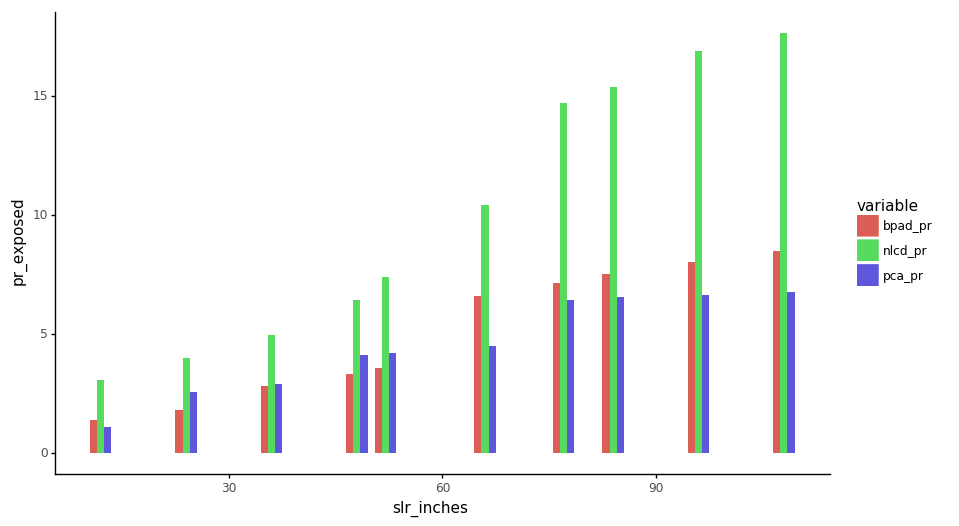

In [39]:
from IPython.display import Image
Image(plotpath)

In [40]:
df = data.melt(id_vars='slr_inches', value_vars=['pca', 'bpad', 'nlcd'], \
          value_name='pud_exposed')

In [41]:
barplot_pud = gg.ggplot(df[df['slr_inches'] != 0], gg.aes(x='slr_inches', y='pud_exposed', fill='variable')) +\
gg.geom_bar(stat='identity', position='dodge', width=3) +\
gg.theme_classic()

plotpath = os.path.join(workspace, 'rec_barplot2.png')
barplot_pud.save(filename=plotpath, width=10, height=6)

# ggsave(barplot, width=10, height=6, )

/home/dmf/miniconda3/envs/geowork2/lib/python2.7/site-packages/plotnine/ggplot.py:689: UserWarning: Filename: ../data/bcdc_slr_regional_rec/rec_barplot2.png
  warn('Filename: {}'.format(filename))


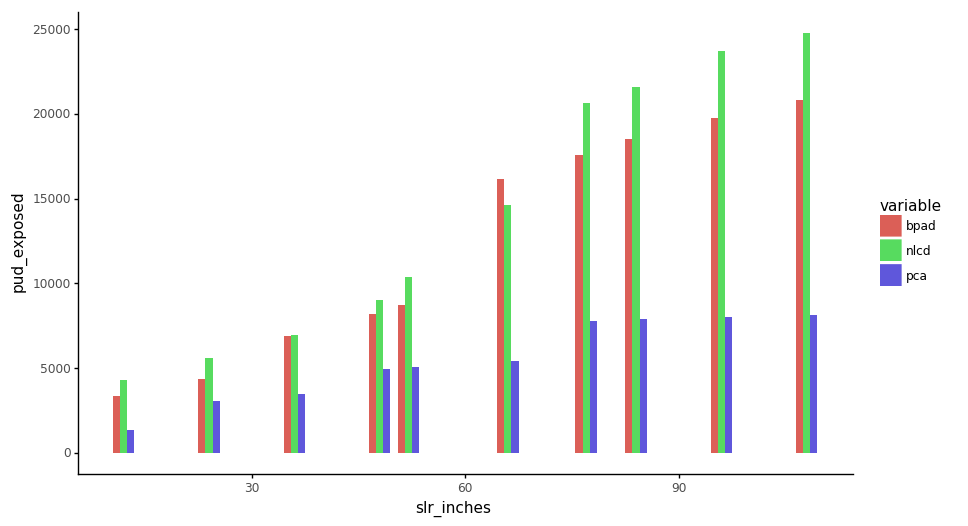

In [42]:
from IPython.display import Image
Image(plotpath)